# Plot the scale height scatter plot 

In [1]:
import numpy as np
import os,glob
import scipy.ndimage as sni
import sys
import re
import itertools
from shutil import copytree
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb
import aplpy
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from photutils import SkyCircularAnnulus
from photutils import SkyCircularAperture
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import SkyEllipticalAperture
from photutils import SkyEllipticalAnnulus
from photutils import EllipticalAperture
from photutils import EllipticalAnnulus
from photutils import aperture_photometry
import numpy.ma as ma
import math
import shutil
import pandas as pd
import seaborn as sns

/home/heh15/packages/miniconda3/envs/Condapy3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


## Function 

Read the aperture from the image

In [2]:
def Apmask_convert(aperture,data_masked):
    data_cut=data_masked.data
    data_mask=data_masked.mask
    apmask=aperture.to_mask(method='center')[0]
    shape=data_cut.shape
    mask=apmask.to_image(shape=((shape[0],shape[1])))
    mask_tmp=mask==0
    ap_mask=np.ma.mask_or(mask_tmp,data_mask)
 #   ap_masked=np.ma.masked_where(ap_mask,data_cut
    return ap_mask

Convert the casa mask to python mask

In [3]:
def masked_convert(data_masked,region_masked):
    data_mask=data_masked.mask
    region_mask=np.ma.make_mask(region_masked==0)
    region_mask=np.ma.mask_or(data_mask,region_mask)
    data_region=np.ma.masked_where(region_mask,data_masked)
    return data_region

## Main program 

### Directory 

In [4]:
Dir='/1/home/heh15/workingspace/Arp240/scatter/'
picDir=Dir+'picture/'
imageDir=Dir+'image/'
logDir=Dir+'log/'

### Basic constant 

In [5]:
ratio=0.77
XCO=0.5
D=99
z=0.024
beammaj=1.004
beammin=0.556
freq=230.54
alpha=4.3
rms=0.0024
rms_mom0=rms*10*math.sqrt(50) 
incl=0.45

H_coeff=10**6/(2e30*3.14*6.67e-11/(3.1e16))
Jy2K=(0.0109*beammaj*beammin*(freq/115.27)**2)

### Load the data from image directory 

The directory of the image file

In [6]:
mom0=imageDir+'NGC5257/NGC5257_12CO21_pbcor_rebin_mom0.fits'
height=imageDir+'NGC5257/NGC5257_height_rebin.fits'
mom2_1=imageDir+'NGC5257/NGC5257_12CO21_combine_5bin_mom2.fits'
mom2_2=imageDir+'NGC5257/NGC5257_12CO21_combine_mom2_rebin.fits'

#### Import the mom0 map 

In [7]:
hdr=fits.open(mom0)[0].header
wcs=WCS(hdr).celestial
data_mom0=fits.open(mom0)[0].data[0][0]

Selection of the data

In [8]:
threshold=data_mom0<5.0*rms_mom0
data_mom0[threshold]='nan'
print(rms_mom0)
data_mom0=data_mom0*incl

0.1697056274847714


/home/heh15/packages/miniconda3/envs/Condapy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


Conversion of the data from jansky to the solar mass/pc^2

In [9]:
data_K=data_mom0/(0.0109*beammaj*beammin*(freq/115.27)**2)
sd=alpha/ratio*data_K

#### Import the scale height map

In [10]:
hdr=fits.open(height)[0].header
wcs=WCS(hdr).celestial
height=fits.open(height)[0].data[0][0]*incl

Covert the scale height to the physical unit

In [11]:
H=H_coeff*Jy2K*height

#### Check the 50% coverage for scale height map. 

In [12]:
coverage=imageDir+'NGC5257/NGC5257_mask50percent.fits'
hdr=fits.open(coverage)[0].header
wcs=WCS(hdr).celestial
mask=fits.open(coverage)[0].data[0][0]

Covert the coverage map to the mask and add it to the height

In [13]:
low_cov=np.isnan(mask)
H_masked=np.copy(H)
H_masked[~low_cov]='nan'
orig=np.isnan(H)
sd_masked=np.copy(sd)
sd_masked[low_cov]='nan'
np.count_nonzero(~np.isnan(sd))

467

scatter plot

(10, 10000)

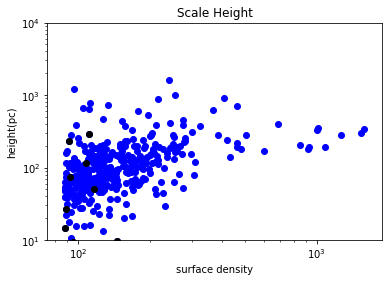

In [14]:
fig=plt.figure()
ax=plt.axes(xscale='log',yscale='log')
plt.scatter(sd,H,color='blue')
plt.scatter(sd,H_masked,color='black')
plt.title('Scale Height')
plt.xlabel('surface density')
plt.ylabel('height(pc)')
plt.ylim(10,10000)

### Compare the moment 2 map binned from cube and binned from moment 2 map 

#### Import the map binned from the cube 

In [15]:
hdr=fits.open(mom2_1)[0].header
wcs=WCS(hdr).celestial
mom2_1=fits.open(mom2_1)[0].data[0][0]

#### Import the map binned from the moment 2 map 

In [16]:
hdr=fits.open(mom2_2)[0].header
wcs=WCS(hdr).celestial
mom2_2=fits.open(mom2_2)[0].data[0][0]

#### plot the surface density vs dispersion 

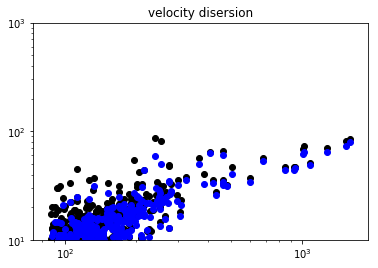

In [17]:
fig=plt.figure()
ax=plt.axes(xscale='log',yscale='log')
plt.title('velocity disersion')
plt.ylim(10,1000)
plt.scatter(sd,mom2_1,color='black')
plt.scatter(sd,mom2_2,color='blue')

In [18]:
vd=np.copy(mom2_1) 
low_value_flags=mom2_1<1.0
vd[low_value_flags]='nan'
height_orig=H_coeff*vd**2/sd

/home/heh15/packages/miniconda3/envs/Condapy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


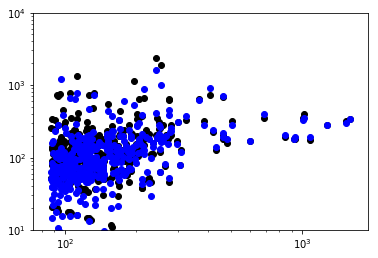

In [19]:
fig=plt.figure()
ax=plt.axes(xscale='log',yscale='log')
plt.ylim(10,10000)
plt.scatter(sd,height_orig,color='black')
plt.scatter(sd,H,color='blue')

Record the scale height into the text file. 

In [20]:
data=np.transpose(np.vstack([sd.flatten(),H.flatten()]))
filename=logDir+'Sd_H.txt'
np.savetxt(filename,data)

### Compare NGC 5257 and NGC 5258

#### parameter 

In [21]:
incl=0.47
position=SkyCoord(dec=0.8319*u.degree,ra=204.9908*u.degree,frame='icrs')

In [22]:
mom0=imageDir+'NGC5258/NGC5258_12CO21_pbcor_rebin_mom0.fits'
height=imageDir+'NGC5258/NGC5258_height_rebin.fits'

hdr=fits.open(mom0)[0].header
wcs=WCS(hdr).celestial
data_mom0=fits.open(mom0)[0].data[0][0]
threshold=data_mom0<5.0*rms_mom0
data_mom0[threshold]='nan'
data_mom0=data_mom0*incl

data_K=data_mom0/(0.0109*beammaj*beammin*(freq/115.27)**2)

sd2=alpha/ratio*data_K
hdr=fits.open(height)[0].header
wcs=WCS(hdr).celestial
height=fits.open(height)[0].data[0][0]*incl
H2=H_coeff*Jy2K*height

/home/heh15/packages/miniconda3/envs/Condapy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


#### Check the coverage of the NGC5258

In [23]:
coverage=imageDir+'NGC5258/NGC5258_mask50percent.fits'
hdr=fits.open(coverage)[0].header
wcs=WCS(hdr).celestial
mask=fits.open(coverage)[0].data[0][0]
low_cov=np.isnan(mask)
sd2_masked=np.copy(sd2)
sd2_masked[low_cov]='nan'
print(np.count_nonzero(~np.isnan(sd2)))

1217


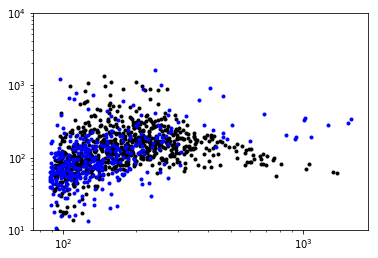

In [24]:
fig=plt.figure()
ax=plt.axes(xscale='log',yscale='log')
plt.ylim(10,10000)
plt.scatter(sd2,H2,color='black',marker='.')
plt.scatter(sd_masked,H,color='blue',marker='.')

#### Number of pixels

In [25]:
print(np.count_nonzero(~np.isnan(H)))
print(np.count_nonzero(~np.isnan(H2)))

1239
1499


In [26]:
def fits_import(fitsimage):
    hdr = fits.open(fitsimage)[0].header
    wcs = WCS(hdr).celestial
    data=fits.open(fitsimage)[0].data
    data=np.squeeze(data)
    size=u.Quantity((54,42),u.arcsec)
    cut=Cutout2D(data=data,position=position,size=size,wcs=wcs)
    data_cut=cut.data
    wcs_cut=cut.wcs
    data_masked=np.ma.masked_invalid(data_cut)
    return wcs_cut, data_masked

In [27]:
fitsimage=imageDir+'NGC5258/NGC5258_height_rebin.fits'
wcs_cut=fits_import(fitsimage)[0]
height=fits_import(fitsimage)[1]

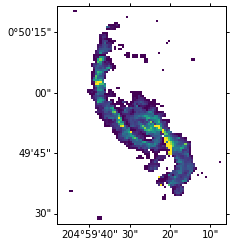

In [28]:
fig=plt.figure()
ax=plt.subplot('111',projection=wcs_cut)
ax.imshow(H_coeff*Jy2K*height,origin='lower',vmax=1000)

In [45]:
index1=np.where(np.isnan(sd))
H[index1]='nan'

index2=np.where(np.isnan(H))
sd[index2]='nan'

In [51]:
outputfits=imageDir+'NGC5257/sd_casa.fits'
hdul=fits.open(mom0)
hdul[0].data=sd
hdul.writeto(outputfits)
hdul.close()

In [52]:
outputfits=imageDir+'NGC5257/height_casa.fits'
hdul=fits.open(mom0)
hdul[0].data=H
hdul.writeto(outputfits)
hdul.close()

In [50]:
np.count_nonzero(~np.isnan(H))

403